# Evaluate Monthly Trend of Land Parcel NDVI using Statistical API

In [1]:
import os
import yaml
from munch import munchify

### _Setup configuration and environment_

In [2]:
# define repo name and get root working directory
repo = 'statistical-api'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]

# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-2' )

In [3]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-2' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\statistical-api\\cfg\\sentinel-2'

In [4]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 's2-ndvi-water-mask.yml' )

In [5]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |       

                //VERSION=3
                function setup() {
                    return {
                        input: [{
                            bands: [
                                "B04",
                                "B08",
                                "SCL",
                                "dataMask"
                            ]
                        }],
                        output: [
                            {
                                id: "data",
                                bands: 1
                            },
                            {
                                id: "dataMask",
                                bands: 1
                            }]
                    }
                }

                function evaluatePixel(samples) {
                    let ndvi = (samples.B08 - samples.B04)/(samples.B08 + samples.B04)

                    var validNDVIMask = 1
                    if (samples.B

In [6]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )
config

Munch({'request': Munch({'evalscript': '\n//VERSION=3\nfunction setup() {\n    return {\n        input: [{\n            bands: [\n                "B04",\n                "B08",\n                "SCL",\n                "dataMask"\n            ]\n        }],\n        output: [\n            {\n                id: "data",\n                bands: 1\n            },\n            {\n                id: "dataMask",\n                bands: 1\n            }]\n    }\n}\n\nfunction evaluatePixel(samples) {\n    let ndvi = (samples.B08 - samples.B04)/(samples.B08 + samples.B04)\n\n    var validNDVIMask = 1\n    if (samples.B08 + samples.B04 == 0 ){\n        validNDVIMask = 0\n    }\n\n    var noWaterMask = 1\n    if (samples.SCL == 6 ){\n        noWaterMask = 0\n    }\n\n    //Exclude nodata pixels, pixels where ndvi is not defined and water pixels from statistics:\n    return {\n        data: [ndvi],\n        dataMask: [samples.dataMask * validNDVIMask * noWaterMask]\n    }\n}\n', 'inputs': [Munch(

### _Replicate use case results taken from Sentinel-Hub documentation_

In [7]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

coords = "[ [ [ 458085.878866, 5097236.833044 ], [ 457813.834156, 5096808.351383 ], [ 457979.897062, 5096313.767184 ],  [ 458146.639373, 5096405.411294 ], [ 458085.878866, 5097236.833044 ] ] ]"

df = pd.DataFrame([["Polygon", coords ]], columns=["type", "coords"])
gdf = gpd.GeoDataFrame( geometry=gpd.GeoSeries( Polygon(eval(df.coords.iloc[0])[0] ) ) )
gdf = gdf.set_crs( 32633 )
gdf

,geometry
0,"POLYGON ((458085.879 5097236.833, 457813.834 5..."


In [8]:
gdf = gdf.to_crs(4326)
bounds = gdf.bounds.values[ 0 ]
cx = (bounds[ 2 ] + bounds[ 0 ]) / 2.0
cy = (bounds[ 3 ] + bounds[ 1 ]) / 2.0
cx, cy

(14.457122499992728, 46.02326499999474)

In [9]:
import folium
m = folium.Map(location=[ cy, cx ], zoom_start=14, tiles='CartoDB positron')

for _, r in gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
m

In [10]:
# define aggregation timeframe
from datetime import datetime
timeframe = { 'start' : datetime.strptime('2020-01-01', '%Y-%m-%d'), 
              'end' : datetime.strptime('2020-12-31', '%Y-%m-%d') }

In [11]:
# create instance of shclient class
from statisticalapi import Client
client = Client( config )

In [12]:
# submit request
gdf = gdf.to_crs( 32633 )
response = { '2020' : client.getStatistics( [ timeframe ], resolution=10, polygons=gdf, interval='P30D' ) }

In [13]:
response[ '2020' ]._dfs[ 0 ]

,interval_from,interval_to,data_B0_min,data_B0_max,data_B0_mean,data_B0_stDev,data_B0_sampleCount,data_B0_noDataCount
0,2020-01-01,2020-01-31,0.243067,0.624473,0.412322,0.055875,3036,1192
1,2020-01-31,2020-03-01,0.245194,0.423321,0.316083,0.028077,3036,1192
2,2020-03-01,2020-03-31,0.423614,0.802126,0.584483,0.057668,3036,1192
3,2020-03-31,2020-04-30,0.464754,0.826613,0.661591,0.055393,3036,1192
4,2020-04-30,2020-05-30,0.176174,0.870899,0.688068,0.188334,3036,1192
5,2020-05-30,2020-06-29,0.688319,0.877558,0.823095,0.026851,3036,1192
6,2020-06-29,2020-07-29,0.812419,0.927043,0.897705,0.013219,3036,1192
7,2020-07-29,2020-08-28,0.750795,0.892506,0.843745,0.017706,3036,1192
8,2020-08-28,2020-09-27,0.709407,0.882353,0.813853,0.020640,3036,1192
9,2020-09-27,2020-10-27,0.641610,0.825619,0.736814,0.028841,3036,1192


### _Results extracted from Sentinel-Hub documentation_

{'data': [{'interval': {'from': '2020-01-01T00:00:00Z',
    'to': '2020-01-31T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.24306687712669373,
        'max': 0.6244725584983826,
        'mean': 0.4123224201824293,
        'stDev': 0.055874589607421886,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-01-31T00:00:00Z', 'to': '2020-03-01T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.2451941967010498,
        'max': 0.4233206510543823,
        'mean': 0.3160828609431641,
        'stDev': 0.0280772593636271,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-03-01T00:00:00Z', 'to': '2020-03-31T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.4236144721508026,
        'max': 0.8021259307861328,
        'mean': 0.5844831434836089,
        'stDev': 0.05766820795482124,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-03-31T00:00:00Z', 'to': '2020-04-30T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.4647541046142578,
        'max': 0.8266128897666931,
        'mean': 0.6615912824901472,
        'stDev': 0.05539347152437238,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-04-30T00:00:00Z', 'to': '2020-05-30T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.1761743128299713,
        'max': 0.870899498462677,
        'mean': 0.6880682412526884,
        'stDev': 0.18833356676740057,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-05-30T00:00:00Z', 'to': '2020-06-29T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.6883189082145691,
        'max': 0.8775584697723389,
        'mean': 0.8230951517303176,
        'stDev': 0.026851310273968688,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-06-29T00:00:00Z', 'to': '2020-07-29T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.8124191164970398,
        'max': 0.9270430207252502,
        'mean': 0.8977047195274247,
        'stDev': 0.01321883825220214,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-07-29T00:00:00Z', 'to': '2020-08-28T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.750795304775238,
        'max': 0.8925060033798218,
        'mean': 0.8437445996058478,
        'stDev': 0.017705930134783242,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-08-28T00:00:00Z', 'to': '2020-09-27T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.7094070315361023,
        'max': 0.8823529481887817,
        'mean': 0.8138526516467535,
        'stDev': 0.020639924263070358,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-09-27T00:00:00Z', 'to': '2020-10-27T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.6416097283363342,
        'max': 0.8256189227104187,
        'mean': 0.7368144742384923,
        'stDev': 0.02884084473079313,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-10-27T00:00:00Z', 'to': '2020-11-26T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.5131579041481018,
        'max': 0.9108409285545349,
        'mean': 0.6912739742345253,
        'stDev': 0.06273793790576106,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-11-26T00:00:00Z', 'to': '2020-12-26T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': -0.01446416787803173,
        'max': 0.015364916995167732,
        'mean': 0.0018048733875211391,
        'stDev': 0.004322122712106793,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}}],
 'status': 'OK'}

<AxesSubplot:xlabel='interval_from'>

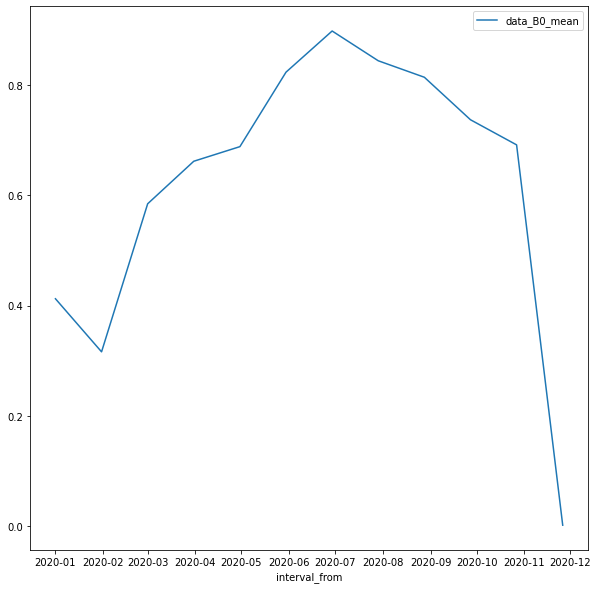

In [14]:
response[ '2020' ]._dfs[ 0 ].plot( figsize=(10,10), x='interval_from', y='data_B0_mean')

### _Repeat NDVI Statistical Analysis for 2019_

In [15]:
# define aggregation timeframe
from datetime import datetime
timeframe = { 'start' : datetime.strptime('2019-01-01', '%Y-%m-%d'), 
              'end' : datetime.strptime('2019-12-31', '%Y-%m-%d') }

In [16]:
# submit request
response[ '2019' ] = client.getStatistics( [ timeframe ], resolution=10, polygons=gdf, interval='P30D' )

In [17]:
response[ '2019' ]._dfs[ 0 ]

,interval_from,interval_to,data_B0_min,data_B0_max,data_B0_mean,data_B0_stDev,data_B0_sampleCount,data_B0_noDataCount
0,2019-01-01,2019-01-31,0.469809,0.815842,0.618367,0.064358,3036,1192
1,2019-01-31,2019-03-02,0.389908,0.768480,0.538281,0.060874,3036,1192
2,2019-03-02,2019-04-01,0.376801,0.809939,0.572976,0.071262,3036,1192
3,2019-04-01,2019-05-01,0.380990,0.700559,0.560569,0.055074,3036,1192
4,2019-05-01,2019-05-31,0.694432,0.877473,0.811056,0.023321,3036,1192
5,2019-05-31,2019-06-30,0.797827,0.901928,0.862354,0.015903,3036,1192
6,2019-06-30,2019-07-30,0.794118,0.922197,0.890052,0.015023,3036,1192
7,2019-07-30,2019-08-29,0.706647,0.908904,0.837857,0.023716,3036,1192
8,2019-08-29,2019-09-28,0.731110,0.921393,0.870986,0.020588,3036,1192
9,2019-09-28,2019-10-28,0.058035,0.383510,0.109206,0.036633,3036,1192


<AxesSubplot:>

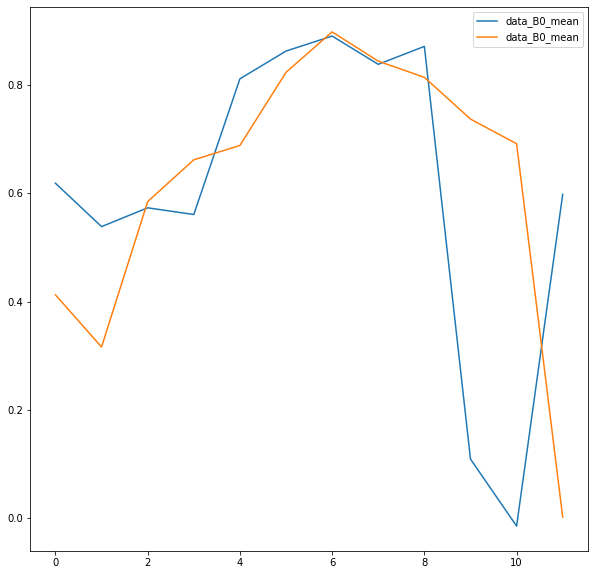

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( figsize=(10,10) )
response[ '2019' ]._dfs[ 0 ].plot( ax=ax, y='data_B0_mean')
response[ '2020' ]._dfs[ 0 ].plot( ax=ax, y='data_B0_mean')